CSC with a Spatial Mask
=======================

This example demonstrates the use of [cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) for convolutional sparse coding with a spatial mask [[47]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-boundary). The example problem is inpainting of randomly distributed corruption of a colour image [[48]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional).

In [1]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import signal
from sporco import plot
plot.config_notebook_plotting()
from sporco.admm import tvl2
from sporco.admm import cbpdn
from sporco.metric import psnr

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
np.random.seed(12345)
frc = 0.5
msk = signal.rndmask(img.shape, frc, dtype=np.float32)
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x: np.pad(x, ((pn, pn), (pn, pn), (0, 0)), mode='symmetric')
zpad = lambda x: np.pad(x, ((pn, pn), (pn, pn), (0, 0)), mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter. The highpass component is the difference between the test image and the lowpass component, multiplied by the mask for faster convergence of the convolutional sparse coding (see [[57]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2017-convolutional3)).

In [6]:
lmbda = 0.05
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
                    'DFidWeight': mskp, 'gEvalY': False,
                    'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(imgwp, lmbda, opt, caxis=2)
sl = b.solve()
sh = mskp * (imgwp - sl)

Load dictionary.

In [7]:
D = util.convdicts()['RGB:8x8x3x64']

Set up [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) options.

In [8]:
lmbda = 2e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False, 'RelaxParam': 1.8,
                    'rho': 5e1*lmbda + 1e-1, 'AutoRho': {'Enabled': False,
                    'StdResiduals': False}})

Construct [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) wrapper for [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) and solve via wrapper. This example could also have made use of [admm.cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl), which has similar performance in this application, but [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) has the advantage of greater flexibility in that the wrapper can be applied to a variety of CSC solver objects.

In [9]:
ams = cbpdn.AddMaskSim(cbpdn.ConvBPDN, D, sh, mskp, lmbda, opt=opt)
X = ams.solve()

Itn   Fnc       DFid      Regℓ1     r         s       
------------------------------------------------------


   0  3.61e+01  2.40e+00  1.69e+03  9.50e-01  6.10e-01


   1  3.42e+01  4.54e+00  1.48e+03  3.68e-01  5.88e-01


   2  2.96e+01  2.83e+00  1.34e+03  2.11e-01  2.91e-01


   3  2.73e+01  2.39e+00  1.24e+03  1.58e-01  1.98e-01


   4  2.61e+01  2.23e+00  1.19e+03  1.32e-01  1.50e-01


   5  2.53e+01  2.18e+00  1.16e+03  1.15e-01  1.21e-01


   6  2.43e+01  2.18e+00  1.11e+03  1.02e-01  1.04e-01


   7  2.35e+01  2.21e+00  1.06e+03  9.21e-02  9.08e-02


   8  2.27e+01  2.26e+00  1.02e+03  8.40e-02  8.07e-02


   9  2.22e+01  2.31e+00  9.93e+02  7.69e-02  7.22e-02


  10  2.17e+01  2.37e+00  9.67e+02  7.10e-02  6.53e-02


  11  2.13e+01  2.42e+00  9.42e+02  6.58e-02  5.96e-02


  12  2.08e+01  2.46e+00  9.15e+02  6.11e-02  5.48e-02


  13  2.02e+01  2.51e+00  8.87e+02  5.70e-02  5.06e-02


  14  1.97e+01  2.55e+00  8.59e+02  5.33e-02  4.68e-02


  15  1.92e+01  2.59e+00  8.32e+02  4.99e-02  4.37e-02


  16  1.88e+01  2.62e+00  8.07e+02  4.69e-02  4.10e-02


  17  1.83e+01  2.66e+00  7.84e+02  4.42e-02  3.84e-02


  18  1.80e+01  2.69e+00  7.64e+02  4.18e-02  3.59e-02


  19  1.76e+01  2.72e+00  7.45e+02  3.96e-02  3.38e-02


  20  1.73e+01  2.74e+00  7.27e+02  3.75e-02  3.18e-02


  21  1.70e+01  2.77e+00  7.11e+02  3.56e-02  2.99e-02


  22  1.67e+01  2.79e+00  6.96e+02  3.39e-02  2.82e-02


  23  1.65e+01  2.81e+00  6.83e+02  3.22e-02  2.66e-02


  24  1.62e+01  2.83e+00  6.70e+02  3.07e-02  2.52e-02


  25  1.60e+01  2.84e+00  6.58e+02  2.93e-02  2.38e-02


  26  1.58e+01  2.86e+00  6.47e+02  2.79e-02  2.27e-02


  27  1.56e+01  2.87e+00  6.36e+02  2.67e-02  2.16e-02


  28  1.54e+01  2.88e+00  6.25e+02  2.55e-02  2.06e-02


  29  1.52e+01  2.89e+00  6.16e+02  2.44e-02  1.97e-02


  30  1.50e+01  2.90e+00  6.06e+02  2.34e-02  1.89e-02


  31  1.49e+01  2.91e+00  5.98e+02  2.24e-02  1.81e-02


  32  1.47e+01  2.92e+00  5.91e+02  2.15e-02  1.73e-02


  33  1.46e+01  2.93e+00  5.84e+02  2.07e-02  1.65e-02


  34  1.45e+01  2.94e+00  5.78e+02  1.99e-02  1.57e-02


  35  1.44e+01  2.94e+00  5.72e+02  1.91e-02  1.51e-02


  36  1.42e+01  2.95e+00  5.65e+02  1.84e-02  1.45e-02


  37  1.41e+01  2.95e+00  5.59e+02  1.77e-02  1.39e-02


  38  1.40e+01  2.96e+00  5.52e+02  1.71e-02  1.34e-02


  39  1.39e+01  2.96e+00  5.47e+02  1.65e-02  1.29e-02


  40  1.38e+01  2.97e+00  5.41e+02  1.59e-02  1.25e-02


  41  1.37e+01  2.97e+00  5.36e+02  1.54e-02  1.20e-02


  42  1.36e+01  2.97e+00  5.32e+02  1.49e-02  1.16e-02


  43  1.35e+01  2.98e+00  5.27e+02  1.44e-02  1.12e-02


  44  1.34e+01  2.98e+00  5.23e+02  1.39e-02  1.09e-02


  45  1.34e+01  2.98e+00  5.19e+02  1.35e-02  1.05e-02


  46  1.33e+01  2.99e+00  5.15e+02  1.30e-02  1.02e-02


  47  1.32e+01  2.99e+00  5.11e+02  1.26e-02  9.88e-03


  48  1.31e+01  2.99e+00  5.07e+02  1.23e-02  9.56e-03


  49  1.31e+01  3.00e+00  5.04e+02  1.19e-02  9.23e-03


  50  1.30e+01  3.00e+00  5.01e+02  1.15e-02  8.93e-03


  51  1.30e+01  3.00e+00  4.98e+02  1.12e-02  8.65e-03


  52  1.29e+01  3.00e+00  4.95e+02  1.09e-02  8.37e-03


  53  1.28e+01  3.01e+00  4.92e+02  1.06e-02  8.12e-03


  54  1.28e+01  3.01e+00  4.89e+02  1.03e-02  7.86e-03


  55  1.27e+01  3.01e+00  4.86e+02  9.99e-03  7.61e-03


  56  1.27e+01  3.01e+00  4.83e+02  9.72e-03  7.37e-03


  57  1.26e+01  3.02e+00  4.81e+02  9.46e-03  7.15e-03


  58  1.26e+01  3.02e+00  4.79e+02  9.21e-03  6.94e-03


  59  1.25e+01  3.02e+00  4.76e+02  8.96e-03  6.74e-03


  60  1.25e+01  3.02e+00  4.74e+02  8.73e-03  6.56e-03


  61  1.25e+01  3.02e+00  4.72e+02  8.51e-03  6.38e-03


  62  1.24e+01  3.03e+00  4.70e+02  8.29e-03  6.22e-03


  63  1.24e+01  3.03e+00  4.68e+02  8.08e-03  6.05e-03


  64  1.23e+01  3.03e+00  4.66e+02  7.88e-03  5.89e-03


  65  1.23e+01  3.03e+00  4.64e+02  7.69e-03  5.75e-03


  66  1.23e+01  3.03e+00  4.62e+02  7.51e-03  5.62e-03


  67  1.22e+01  3.03e+00  4.60e+02  7.33e-03  5.49e-03


  68  1.22e+01  3.03e+00  4.58e+02  7.15e-03  5.37e-03


  69  1.21e+01  3.04e+00  4.56e+02  6.98e-03  5.25e-03


  70  1.21e+01  3.04e+00  4.54e+02  6.82e-03  5.13e-03


  71  1.21e+01  3.04e+00  4.52e+02  6.67e-03  5.01e-03


  72  1.21e+01  3.04e+00  4.51e+02  6.52e-03  4.90e-03


  73  1.20e+01  3.04e+00  4.49e+02  6.38e-03  4.79e-03


  74  1.20e+01  3.04e+00  4.48e+02  6.24e-03  4.69e-03


  75  1.20e+01  3.04e+00  4.46e+02  6.10e-03  4.60e-03


  76  1.19e+01  3.04e+00  4.45e+02  5.97e-03  4.50e-03


  77  1.19e+01  3.04e+00  4.44e+02  5.84e-03  4.42e-03


  78  1.19e+01  3.05e+00  4.42e+02  5.72e-03  4.33e-03


  79  1.19e+01  3.05e+00  4.41e+02  5.60e-03  4.25e-03


  80  1.18e+01  3.05e+00  4.40e+02  5.49e-03  4.17e-03


  81  1.18e+01  3.05e+00  4.38e+02  5.37e-03  4.10e-03


  82  1.18e+01  3.05e+00  4.37e+02  5.27e-03  4.02e-03


  83  1.18e+01  3.05e+00  4.36e+02  5.17e-03  3.94e-03


  84  1.18e+01  3.05e+00  4.35e+02  5.07e-03  3.86e-03


  85  1.17e+01  3.05e+00  4.34e+02  4.97e-03  3.78e-03
------------------------------------------------------


Reconstruct from representation.

In [10]:
imgr = crop(sl + ams.reconstruct().squeeze())

Display solve time and reconstruction performance.

In [11]:
print("AddMaskSim wrapped ConvBPDN solve time: %.2fs" %
      ams.timer.elapsed('solve'))
print("Corrupted image PSNR: %5.2f dB" % psnr(img, imgw))
print("Recovered image PSNR: %5.2f dB" % psnr(img, imgr))

AddMaskSim wrapped ConvBPDN solve time: 49.15s
Corrupted image PSNR: 10.57 dB
Recovered image PSNR: 29.37 dB


Display reference, test, and reconstructed image

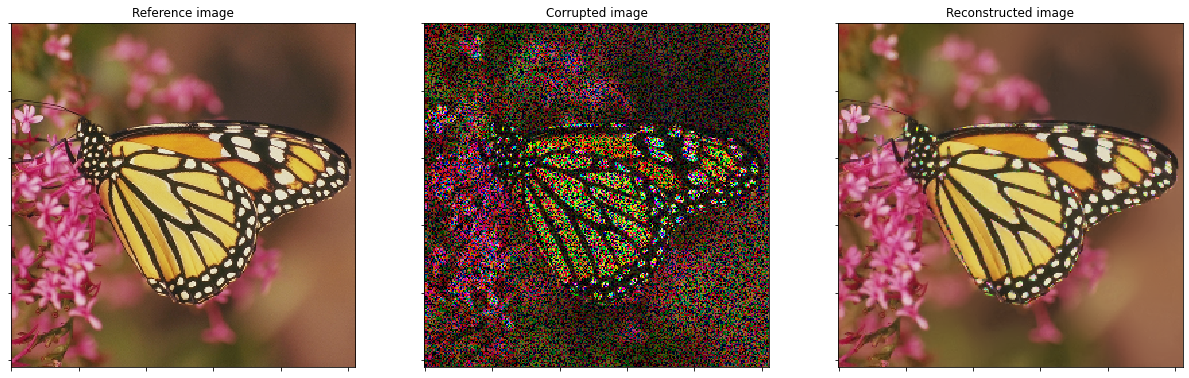

In [12]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, title='Reference image', fig=fig)
plot.subplot(1, 3, 2)
plot.imview(imgw, title='Corrupted image', fig=fig)
plot.subplot(1, 3, 3)
plot.imview(imgr, title='Reconstructed image', fig=fig)
fig.show()

Display lowpass component and sparse representation

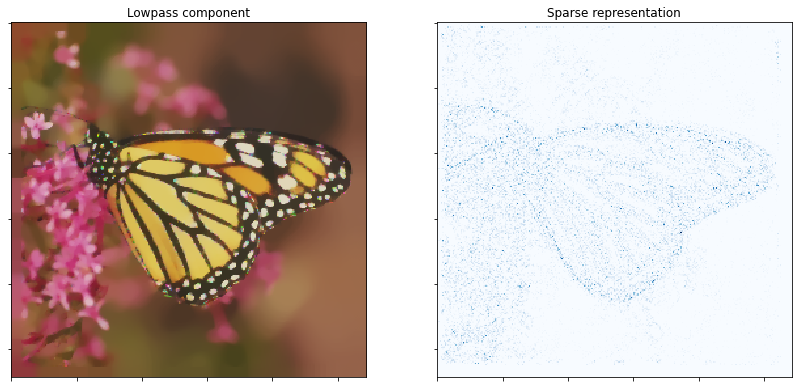

In [13]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(sl, cmap=plot.cm.Blues, title='Lowpass component', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(np.squeeze(np.sum(abs(X), axis=ams.cri.axisM)),
            cmap=plot.cm.Blues, title='Sparse representation', fig=fig)
fig.show()

Plot functional value, residuals, and rho

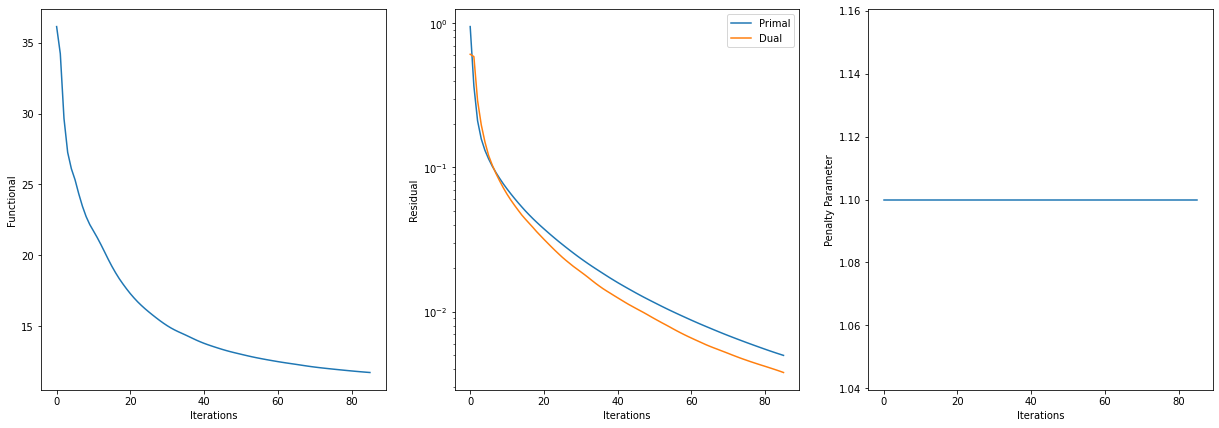

In [14]:
its = ams.getitstat()
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, ptyp='semilogy',
          xlbl='Iterations', ylbl='Residual', lgnd=['Primal', 'Dual'],
          fig=fig)
plot.subplot(1, 3, 3)
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', fig=fig)
fig.show()